# Case Study: Panama Papers

The Panama Papers represent a massive leak of offshore corporate entity information (several hundred thousand entities) from the Panamanian law firm Mossack Fonseca. The papers unveil a never-before-seen network of money laundering connections.

With this notebook, you will learn how to convert a huge CSV file describing connections between entities and officials into a social network without using Pandas. 

You will also learn how to make simple conclusions about the resulting network.

The “Panama” network is social network: it describes relationships between organizations and individuals traced through electronic documentation. The network is available in five CSV files, summarized below:


all_edges.csv
Types: Edges	
Purpose: Each edge has a type of the represented relationship.
number of rows: 1,269,796
columns of interests: node_1, rel_type, node_2

Adresses.csv 
Types: Nodes
Purpose: Legal Addresses
number of rows: 151,127
columns of interests: n/a

Entities.csv 
Types: Nodes
Purpose:  Legal entities (corporations, firms, and so on). 
number of rows: 319,421
columns of interests: name, jurisdiction

Intermediaries.csv 
Types: Nodes
Purpose: Persons and organizations that act as links between other organizations 
number of rows: 23,642
columns of interests: name, country_code

Officers.csv 
Types: Nodes
Purpose: Persons (directors, shareholders, and so on). 
number of rows: 345,645
columns of interests: name, country_code

In [1]:
"""
Analyze "Panama Papers"
"""
import csv
import pickle
import itertools
from collections import Counter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import dzcnapy_plotlib as dzcnapy

In [2]:
EDGES = "beneficiary"
NODES = (("PanamaPapers/Entities.csv", "Entities", "jurisdiction", "name"),
         ("PanamaPapers/Officers.csv", "Officers", "country_codes", "name"),
         ("PanamaPapers/Intermediaries.csv", "Intermediaries", "country_codes", "name"))

In [3]:
panama = nx.Graph()

In [4]:
with open("PanamaPapers/all_edges.csv") as infile:
    data = csv.DictReader(infile)
    panama.add_edges_from((link["node_1"], link["node_2"])
                          for link in data
                          if link["rel_type"].lower().startswith(EDGES))

In [5]:
nodes = set(panama.nodes())
relabel = {}

In [6]:
'''The purpose of the dictionary nodes is to facilitate future lookup. (Python lists have linear lookup time.) 
Read each of the files with a CSV dictionary reader and extract and collect the desired attributes. 
Note that there is no need to process rows that do not match any existing node (because your network does not 
“way of the incident edges). When done, update the node attributes country and kind, and relabel the nodes 
to match persons and organizations names.”

Excerpt From: Dmitry Zinoviev. “Complex Network Analysis in Python (for Giancarlo Ruffo).” iBooks. include all nodes and edges) and add any nodes to the graph (because they have been already added by ”
'''

for f, kind, cc, name in NODES:
    with open(f) as infile:
        data = csv.DictReader(infile)
        names_countries = {node["node_id"] :
                           (node[name].strip().upper(), node[cc])
                           for node in data
                           if node["node_id"] in nodes}
    names =     {nid: values[0] for nid, values in names_countries.items()}
    countries = {nid: values[1] for nid, values in names_countries.items()}
    kinds =     {nid: kind      for nid, _      in names_countries.items()}
    nx.set_node_attributes(panama, countries, "country")
    nx.set_node_attributes(panama, kinds, "kind")
    relabel.update(names)

In [7]:
nx.relabel_nodes(panama, relabel, copy=False)

In [8]:
if "ISSUES OF:" in panama:
    panama.remove_node("ISSUES OF:")

if "" in panama:
    panama.remove_node("")

In [9]:
print(nx.number_of_nodes(panama), nx.number_of_edges(panama))

27926 19135


In [10]:
print(nx.density(panama))

4.90745749525652e-05


In [11]:
components = [p.nodes() for p in nx.connected_component_subgraphs(panama)
              if nx.number_of_nodes(p) >= 20
              or nx.number_of_edges(p) >= 20]
panama0 = panama.subgraph(itertools.chain.from_iterable(components))

In [12]:
print(nx.number_of_nodes(panama0), nx.number_of_edges(panama0))

1393 1926


In [13]:
with open("PanamaPapers/panama-beneficiary.pickle", "wb") as outfile:
    pickle.dump(panama0, outfile)

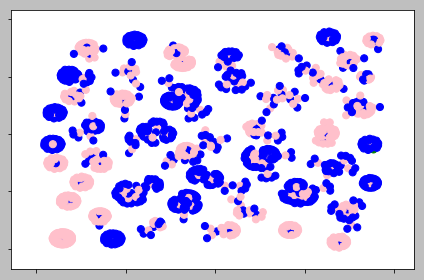

In [14]:
cdict = {"Entities": "pink", "Officers": "blue", 
         "Intermediaries" : "green"}
c = [cdict[panama0.node[n]["kind"]] for n in panama0]
dzcnapy.small_attrs["node_color"] = c
pos = graphviz_layout(panama0)
nx.draw_networkx(panama0, pos=pos, with_labels=False, **dzcnapy.small_attrs)
dzcnapy.set_extent(pos, plt)
dzcnapy.plot("panama0")

In [16]:
nx.attribute_assortativity_coefficient(panama0, "kind")

-0.9896442246627182

In [17]:
nx.attribute_mixing_matrix(panama0, "kind",
                           mapping={"Entities": 0, "Officers": 1,
                                    "Intermediaries" : 2})

array([[  5.19210800e-04,   4.97403946e-01,   2.59605400e-04],
       [  4.97403946e-01,   4.15368640e-03,   0.00000000e+00],
       [  2.59605400e-04,   0.00000000e+00,   0.00000000e+00]])

In [18]:
nx.attribute_assortativity_coefficient(panama0, "country")

-0.17983972430784287

In [19]:
nx.degree_assortativity_coefficient(panama0)

-0.39717073403670283

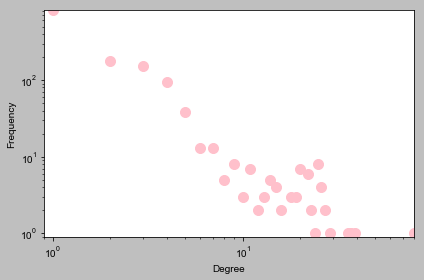

In [28]:
deg = nx.degree(panama0)
x, y = zip(*Counter([d for n, d in deg]).items())

plt.scatter(x, y, s=100, c="pink")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(0.9, max(x))
plt.ylim(0.9, max(y))
plt.xlabel("Degree")
plt.ylabel("Frequency")
dzcnapy.plot("panama-beneficiaries")

In [30]:
top10 = sorted([(n, panama0.node[n]["kind"], v) for n, v in deg],
               key=lambda x: x[2], reverse=True)[:10]
print("\n".join(["{} ({}): {}".format(*t) for t in top10]))

HELITING S.A. (Officers): 80
T.K.B.K. INTERNATIONAL TRUST (Entities): 39
WORLDWIDE COM-NET INTERNATIONAL TRUST (Entities): 37
THE CLAUDIUS TRUST (Entities): 36
GUANGZHOU CONSTRUCTION & DEVELOPMENT HOLDINGS (CHINA)LIMITED (Officers): 29
RICARDO CAMPOLLO CODINA (Officers): 27
ISLANDS INTERNATIONAL TRUST (Entities): 27
MARK OMELNITSKI (Officers): 26
ZEN TRUST (Entities): 26
MR. OLEKSII MYKOLAYOVYCH AZAROV (Officers): 26
